In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 24/24 [01:15<00:00,  3.13s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 359/359 [00:18<00:00, 19.65it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.2581043633336886,
 'epoch': 40,
 'train_loss': 0.7541814,
 'val_loss': 0.67641544,
 'train_acc': 0.3999999761581421,
 'val_acc': 0.4666665494441986,
 'val_rmse_perc': 0.2294699,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.47_4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0_40',
 'train_rmse': 1.0,
 'val_rmse': 0.9660917830792959,
 'test_rmse': 0.970299686427591,
 'train_mae': 0.7333333333333333,
 'val_mae': 0.6666666666666666,
 'test_mae': 0.6585185185185185,
 'train_mcc': 0.25246483906870976,
 'test_mcc': 0.31831948276464905,
 'tes

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.37403179906912004,
 'epoch': 100,
 'train_loss': 0.7099372,
 'val_loss': 0.5451622,
 'train_acc': 0.3523809313774109,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.1935401,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.56_4_[4_4]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0',
 'train_rmse': 0.9206622874969125,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.9376882527040953,
 'train_mae': 0.7142857142857143,
 'val_mae': 0.5111111111111111,
 'test_mae': 0.6718518518518518,
 'train_mcc': 0.23524384470885604,
 'test_mcc': 0.26836532940153884,
 'te

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.4062103742297434,
 'epoch': 30,
 'train_loss': 0.7900251,
 'val_loss': 0.6591515,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.21932301,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.56_4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0',
 'train_rmse': 0.9309493362512627,
 'val_rmse': 0.8819171036881969,
 'test_rmse': 0.8952549812659416,
 'train_mae': 0.7333333333333333,
 'val_mae': 0.5555555555555556,
 'test_mae': 0.6503703703703704,
 'train_mcc': 0.2635988651851568,
 'test_mcc': 0.328269095868

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 359/359 [00:00<00:00, 22497.80it/s]


In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

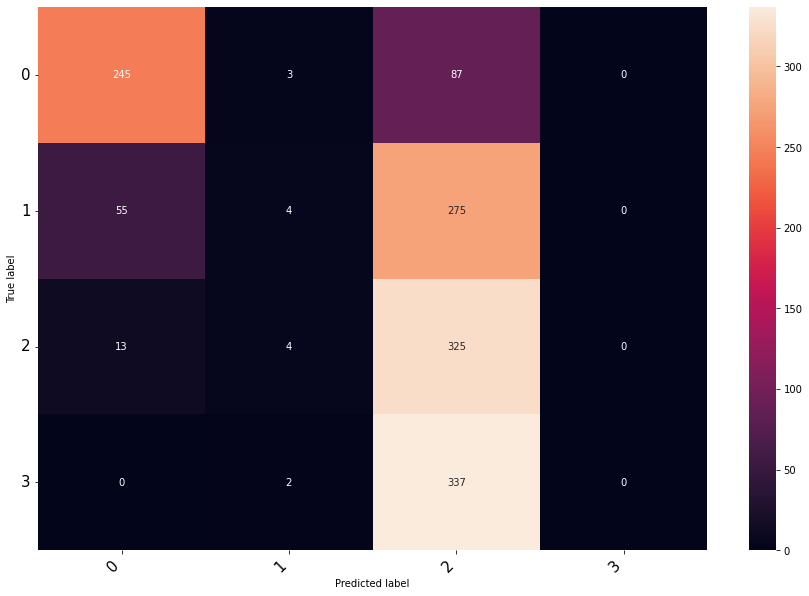

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.7313, 0.0120, 0.9503, 0.0000])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.22770451, 0.25407845, 0.12376542, 0.2617987]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.16797802, 0.23887245, 0.08461432, 0.25129825]

### GCN

In [20]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [07:16<00:00,  6.06s/it]


#### Results

In [22]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1085/1085 [01:05<00:00, 16.54it/s]


In [23]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.34314948952069046,
 'epoch': 50,
 'train_loss': 0.8925844,
 'val_loss': 0.64801407,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.5333331823348999,
 'val_rmse_perc': 0.21801905,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.53_4_[10_15_20]_4_ReLU()_none_None_0.2_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_50',
 'train_rmse': 0.9952267030562386,
 'val_rmse': 0.8944271909999159,
 'test_rmse': 0.9285592184789413,
 'train_mae': 0.7619047619047619,
 'val_mae': 0.5777777777777777,
 'test_mae': 0.6474074074074074,
 'train_mcc': 0.2093384852633761

In [24]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.5032362797401965,
 'epoch': 21,
 'train_loss': 0.9154323,
 'val_loss': 0.5857544,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.6222220659255981,
 'val_rmse_perc': 0.19379173,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.62_4_[5_10_15_20]_4_ReLU()_none_None_0.2_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0.2',
 'train_rmse': 0.9710083124552245,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.9116529554118229,
 'train_mae': 0.7523809523809524,
 'val_mae': 0.4666666666666667,
 'test_mae': 0.6577777777777778,
 'train_mcc': 0.231038910531

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.4062103742297434,
 'epoch': 40,
 'train_loss': 0.8321157,
 'val_loss': 0.5950143,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.20377389,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.56_4_[5_10_15_20]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0.2_40',
 'train_rmse': 0.9611501047232549,
 'val_rmse': 0.8819171036881969,
 'test_rmse': 0.8894442709417556,
 'train_mae': 0.7523809523809524,
 'val_mae': 0.5555555555555556,
 'test_mae': 0.642962962962963,
 'train_mcc': 0.255054964056

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1085/1085 [00:00<00:00, 22203.02it/s]


### GraphSAGE

In [27]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [28]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 168/168 [3:42:37<00:00, 79.51s/it]  


#### Results

In [29]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 2222/2222 [13:08<00:00,  2.82it/s]


True

In [30]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6252941141737133,
 'epoch': 100,
 'train_loss': 0.39772978,
 'val_loss': 0.284676,
 'train_acc': 0.7619047164916992,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.13666311,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.69_4_[30]_1_lstm_none_gn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0',
 'train_rmse': 0.5690426379538917,
 'val_rmse': 0.5577733510227171,
 'test_rmse': 0.6283429118043864,
 'train_mae': 0.26666666666666666,
 'val_mae': 0.3111111111111111,
 'test_mae': 0.3237037037037037,
 'train

In [31]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5581567299627662,
 'epoch': 30,
 'train_loss': 0.23650756,
 'val_loss': 0.27340186,
 'train_acc': 0.7999999523162842,
 'val_acc': 0.6666665077209473,
 'val_rmse_perc': 0.13550916,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.67_4_[15_15]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_30',
 'train_rmse': 0.5345224838248488,
 'val_rmse': 0.5773502691896257,
 'test_rmse': 0.6122212139535961,
 'train_mae': 0.22857142857142856,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.3274074074074074,


In [32]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5581567299627662,
 'epoch': 30,
 'train_loss': 0.23650756,
 'val_loss': 0.27340186,
 'train_acc': 0.7999999523162842,
 'val_acc': 0.6666665077209473,
 'val_rmse_perc': 0.13550916,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.67_4_[15_15]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_30',
 'train_rmse': 0.5345224838248488,
 'val_rmse': 0.5773502691896257,
 'test_rmse': 0.6122212139535961,
 'train_mae': 0.22857142857142856,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.3274074074074074,


In [33]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2222/2222 [00:00<00:00, 18566.26it/s]


#### cm

In [34]:
cm = all[sort_idx[0]]['test_cm'][0]

In [35]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

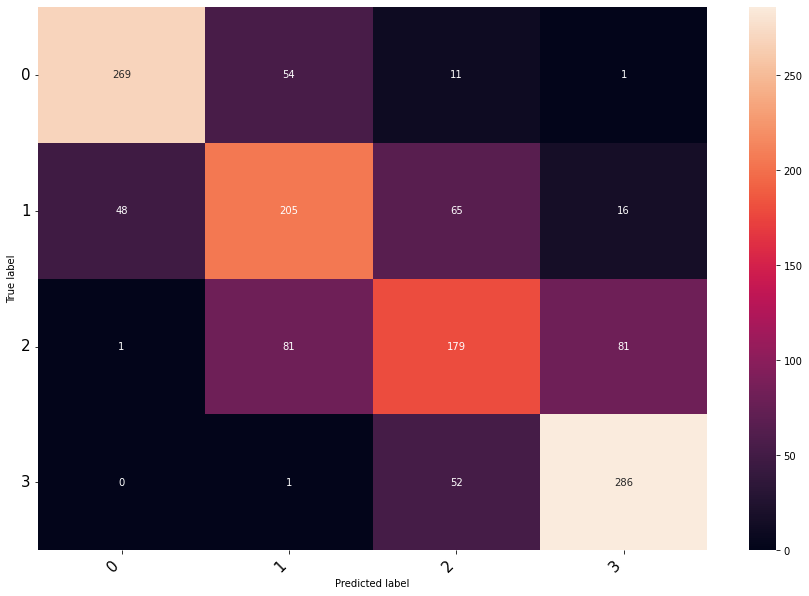

In [36]:
cm.visualize()

In [37]:
cm.class_accuracy

tensor([0.8030, 0.6138, 0.5234, 0.8437])

In [38]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.13790159, 0.15952717, 0.1409811, 0.10497403]

In [39]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08756422, 0.113721356, 0.114313625, 0.07797286]

#### GraphSAGE Base_n

In [40]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [41]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 336/336 [3:39:12<00:00, 39.15s/it]   


##### Results

In [42]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

toast.show_toast("Done")

100%|██████████| 3552/3552 [12:56<00:00,  4.57it/s]


True

In [43]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': None,
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5825517280354631,
 'epoch': 51,
 'train_loss': 0.18656603,
 'val_loss': 0.27363402,
 'train_acc': 0.6095237731933594,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.15756983,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.69_4_[20_20]_1_lstm_none_None_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.6473388749701496,
 'val_rmse': 0.5577733510227171,
 'test_rmse': 0.745852730970596,
 'train_mae': 0.4,
 'val_mae': 0.3111111111111111,
 'test_mae': 0.48518518518518516,
 'train_mcc': 0.496003271

In [44]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': None,
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.5178101625488243,
 'epoch': 44,
 'train_loss': 0.499114,
 'val_loss': 0.36501274,
 'train_acc': 0.5523809194564819,
 'val_acc': 0.6444442868232727,
 'val_rmse_perc': 0.14831002,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.64_4_[20_20]_1_lstm_none_None_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0.2',
 'train_rmse': 0.7237468644557459,
 'val_rmse': 0.5962847939999439,
 'test_rmse': 0.8146801235477049,
 'train_mae': 0.4666666666666667,
 'val_mae': 0.35555555555555557,
 'test_mae': 0.5348148148148149,
 'train

In [45]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4670400755476216,
 'epoch': 70,
 'train_loss': 0.08967816,
 'val_loss': 0.272133,
 'train_acc': 0.5523809194564819,
 'val_acc': 0.6222220659255981,
 'val_rmse_perc': 0.1587855,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.62_4_[30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0_70',
 'train_rmse': 0.6690433824641326,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.7363574011458174,
 'train_mae': 0.44761904761904764,
 'val_mae': 0.4,
 'test_mae': 0.49333333333333335,
 'train_mcc': 0.4337144661414679

In [46]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3552/3552 [00:00<00:00, 21984.66it/s]


##### cm

In [47]:
cm = all[sort_idx[0]]['test_cm'][0]

In [48]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

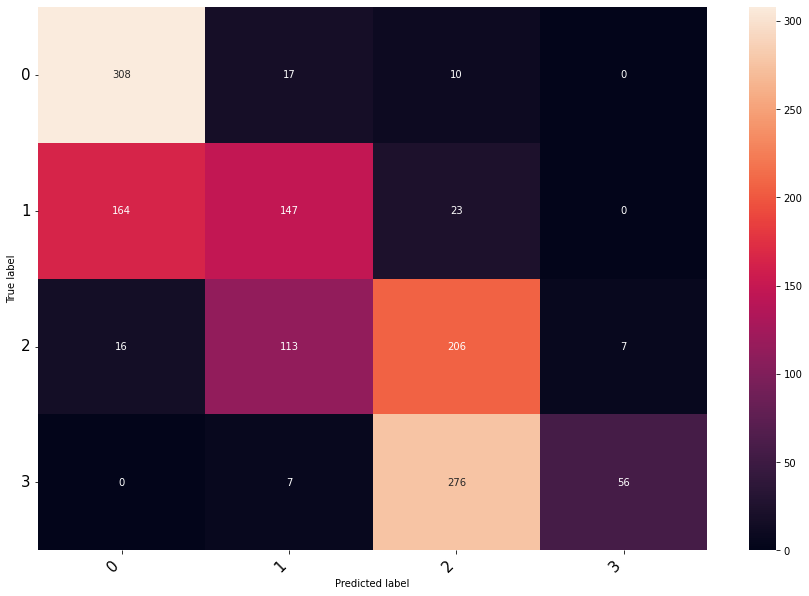

In [49]:
cm.visualize()

In [50]:
cm.class_accuracy

tensor([0.9194, 0.4401, 0.6023, 0.1652])

In [51]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.11353903, 0.15816729, 0.16229323, 0.19910829]

In [52]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08250969, 0.13762578, 0.13359775, 0.18440121]

#### GraphSAGE Scale

In [53]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 336/336 [3:45:07<00:00, 40.20s/it]   


##### Results

In [55]:
res_edges_sage_dist = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

toast.show_toast("Done")

100%|██████████| 6266/6266 [27:31<00:00,  3.79it/s]


True

In [56]:
res_edges = res_edges_sage_dist
res_edges[0]

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6252941141737133,
 'epoch': 100,
 'train_loss': 0.39772978,
 'val_loss': 0.284676,
 'train_acc': 0.7619047164916992,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.13666314,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.69_4_[30]_1_lstm_none_gn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0',
 'train_rmse': 0.5690426379538917,
 'val_rmse': 0.5577733510227171,
 'test_rmse': 0.6283429118043864,
 'train_mae': 0.26666666666666666,
 'val_mae': 0.3111111111111111,
 'test_mae': 0.3237037037037037,
 'train

In [57]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5581567299627662,
 'epoch': 30,
 'train_loss': 0.23650756,
 'val_loss': 0.27340186,
 'train_acc': 0.7999999523162842,
 'val_acc': 0.6666665077209473,
 'val_rmse_perc': 0.1355092,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.67_4_[15_15]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_30',
 'train_rmse': 0.5345224838248488,
 'val_rmse': 0.5773502691896257,
 'test_rmse': 0.6122212139535961,
 'train_mae': 0.22857142857142856,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.3274074074074074,
 

In [58]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5581567299627662,
 'epoch': 30,
 'train_loss': 0.23650756,
 'val_loss': 0.27340186,
 'train_acc': 0.7999999523162842,
 'val_acc': 0.6666665077209473,
 'val_rmse_perc': 0.1355092,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.67_4_[15_15]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_30',
 'train_rmse': 0.5345224838248488,
 'val_rmse': 0.5773502691896257,
 'test_rmse': 0.6122212139535961,
 'train_mae': 0.22857142857142856,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.3274074074074074,
 

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6266/6266 [00:00<00:00, 21815.18it/s]


##### cm

In [60]:
cm = all[sort_idx[0]]['test_cm'][0]

In [61]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

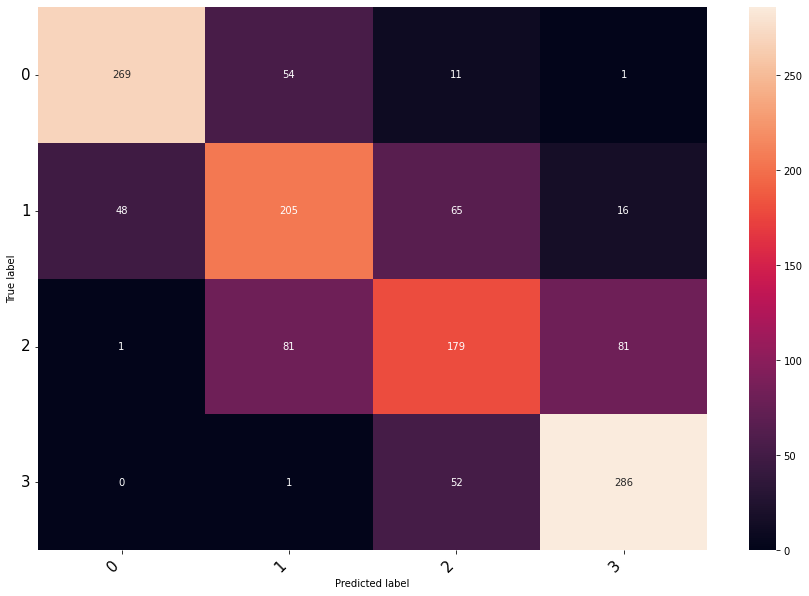

In [62]:
cm.visualize()

In [63]:
cm.class_accuracy

tensor([0.8030, 0.6138, 0.5234, 0.8437])

In [64]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.1379016, 0.15952715, 0.14098111, 0.10497401]

In [65]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08756423, 0.11372137, 0.11431364, 0.07797285]

### GAT

In [66]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [67]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 576/576 [1:01:35<00:00,  6.42s/it]


#### Results

In [68]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 6979/6979 [06:24<00:00, 18.15it/s]


In [69]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.47001970565856954,
 'epoch': 52,
 'train_loss': 0.6789217,
 'val_loss': 0.5104528,
 'train_acc': 0.6571428179740906,
 'val_acc': 0.5999998450279236,
 'val_rmse_perc': 0.19845463,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.60_4_[25_25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_scale-dist_10_True_0',
 'train_rmse': 0.7171371656006361,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.9120591273880504,
 'train_mae': 0.4,
 'val_mae': 0.4666666666666667,
 'test_mae':

In [70]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4857110509116762,
 'epoch': 100,
 'train_loss': 0.53162223,
 'val_loss': 0.47829196,
 'train_acc': 0.6571428179740906,
 'val_acc': 0.5999998450279236,
 'val_rmse_perc': 0.18357994,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.60_4_[25_25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_scale-dist_10_True_0_100',
 'train_rmse': 0.6969320524371696,
 'val_rmse': 0.7302967433402214,
 'test_rmse': 0.9313470928753723,
 'train_mae': 0.3904761904761905,
 'val_mae': 0.444444444

In [71]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.38617035890144813,
 'epoch': 60,
 'train_loss': 0.6469679,
 'val_loss': 0.5689538,
 'train_acc': 0.5999999642372131,
 'val_acc': 0.5333331823348999,
 'val_rmse_perc': 0.1978642,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.53_4_[25]_1_[4_4]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_60',
 'train_rmse': 0.7745966692414834,
 'val_rmse': 0.816496580927726,
 'test_rmse': 0.916110942658835,
 'train_mae': 0.4666666666666667,
 'val_mae': 0.5333333333333333,
 'test

In [72]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6979/6979 [00:00<00:00, 21597.84it/s]
